In [1]:
using Distributions
include("common.jl")
enough_time = 60
using PyPlot

Common file resource included

In [2]:
function calculate_minimum_hamming_distance(motif, string, input_motif_length)
    string_motifs = get_nth_substrings(input_motif_length, string)
    error = input_motif_length
    for substring in string_motifs
        substring_error = calculate_hamming_distance(substring, motif)
        if substring_error < error
            error = substring_error
        end
    end
    return error
end

calculate_minimum_hamming_distance (generic function with 1 method)

In [3]:
function calculate_fitness_score(motif, input_motif_length)
    fitness_score = 0
    # valid = True
    for string in input_strings
        string_score = calculate_minimum_hamming_distance(motif, string, input_motif_length)
        fitness_score = fitness_score + string_score
    end
    return (input_motif_length * length(input_strings)) - fitness_score
end

calculate_fitness_score (generic function with 1 method)

In [4]:
function mutate(motif, motif_characters, all_created_motifs)
    new_motif = generate_adjecent_motif(motif, motif_characters, all_created_motifs)
    if handled_previously(new_motif, all_created_motifs)
        return mutate(motif, motif_characters, all_created_motifs)
    end
    return new_motif
end

mutate (generic function with 1 method)

In [5]:
function reproduce(mom, dad, input_motif_length)
    random_index = rand([i for i in 1:input_motif_length-1])
    if (random_index - input_motif_length) < 0
        idx = input_motif_length + (random_index - input_motif_length) + 1
    else
        idx = (random_index - input_motif_length)
    end
    son = string(mom[1:random_index], dad[idx:end])
    daughter = string(dad[1:random_index], mom[idx:end])
#     son = mom[1:random_index] + dad[idx:end]
#     daughter = dad[1:random_index] + mom[idx:end]
    return (son, daughter)
end

reproduce (generic function with 1 method)

In [6]:
function handled_previously(motif, all_created_motifs)
    return motif in all_created_motifs
end

handled_previously (generic function with 1 method)

In [7]:
function generate_initial_population(size, all_created_motifs, input_motif_length, motif_characters)
    population = []
    for i in 1:size
        motif = generate_random_potential_motif(input_motif_length, motif_characters)
        push!(population, motif)
        push!(all_created_motifs, motif)
    end
    return (collect(Set(population)), collect(Set(all_created_motifs)))
end

generate_initial_population (generic function with 1 method)

In [8]:
function get_random_from_population(population, partner, input_motif_length)
    random_index = rand([i for i in 1:length(population)])
    motif = population[random_index]
    if ((!isempty(partner)) && (partner == motif))
        return get_random_from_population(population, partner, input_motif_length)
    else
        return motif, get_fitness_score_percentage(motif, input_motif_length)
    end
end

get_random_from_population (generic function with 1 method)

In [9]:
function get_fitness_score_percentage(motif, input_motif_length)
    return calculate_fitness_score(motif, input_motif_length) / (input_motif_length * length(input_strings))
end

get_fitness_score_percentage (generic function with 1 method)

In [10]:
function genetic_algorithm(size, input_motif_length, all_created_motifs, motif_characters, input_hamming_distance)
    ga_time = time()
    done = false
    answer = ""
    answer_score = 0
    most_close_to_answer = ""
    most_close_to_answer_score = 0
    (population, all_created_motifs) = generate_initial_population(size, all_created_motifs, input_motif_length, motif_characters)
    while !done
        new_population = []
        if(length(population) < size)
            for i in 1:size - length(population)
                push!(population, generate_random_potential_motif(input_motif_length, motif_characters))
            end
        end
        for i in 1:length(population)
            (random_motif_dad, dad_fitness_score) = get_random_from_population(population, [], input_motif_length)
            (best_motif, best_score) = (random_motif_dad, dad_fitness_score)
            (random_motif_mom, mom_fitness_score) = get_random_from_population(population, random_motif_dad, input_motif_length)
            if mom_fitness_score > best_score
                (best_motif, best_score) = (random_motif_mom, mom_fitness_score)
            end
            (motif_son, motif_daughter) = reproduce(random_motif_mom, random_motif_dad, input_motif_length)
#             print("\n", motif_son, " is child of ", random_motif_mom, " and ", random_motif_dad, "!")
#             print("\n", motif_daughter, " is child of ", random_motif_mom, " and ", random_motif_dad, '!')
            random_probability = rand(Uniform(0, 1))
            son_score = get_fitness_score_percentage(motif_son, input_motif_length)
            if son_score > best_score
                (best_motif, best_score) = (motif_son, son_score)
            elseif random_probability < 0.1
                motif_son = mutate(motif_son, motif_characters, all_created_motifs)
                son_score = get_fitness_score_percentage(motif_son, input_motif_length)
                if son_score > best_score
                    (best_motif, best_score) = (motif_son, son_score)
                end
            end

            daughter_score = get_fitness_score_percentage(motif_daughter, input_motif_length)
            if daughter_score > best_score
                (best_motif, best_score) = (motif_daughter, daughter_score)
            elseif random_probability < 0.1
                motif_daughter = mutate(motif_daughter, motif_characters, all_created_motifs)
                daughter_score = get_fitness_score_percentage(motif_daughter, input_motif_length)
                if daughter_score > best_score
                    (best_motif, best_score) = (motif_daughter, daughter_score)
                end
            end

            if son_score > daughter_score
                push!(new_population, motif_son)
            else
                push!(new_population, motif_daughter)
            end

            if (isempty(most_close_to_answer) || best_score > most_close_to_answer_score)
                (most_close_to_answer, most_close_to_answer_score) = (best_motif, best_score)
            end
#             print(best_motif, " is best motif with fitness of ", string(get_fitness_score_percentage(best_motif, input_motif_length)))
            push!(new_population, best_motif)
        end
        population = collect(Set(new_population))

        if time() - ga_time > enough_time
            done = true
        end
        for motif in population
            if is_motif_valid(motif, input_hamming_distance, input_motif_length) == true
                done = true
                answer = motif
                answer_score = get_fitness_score_percentage(answer, input_motif_length)
                break
            end
        end
    end
    
    if !isempty(answer)
        return Dict("best_answer"=>answer, "best_score"=>answer_score)
    else
        return Dict("best_answer"=>most_close_to_answer, "best_score"=>most_close_to_answer_score)
    end
end



genetic_algorithm (generic function with 1 method)

In [14]:
size = 50
answers = []
elapsed_times = []
mo_lens = []
for mo_len in 5:size-5
    st = time()
    answer = genetic_algorithm(size, mo_len, [], ["A", "C", "G", "T"], 1)

    print("\nBest found motif is ", answer["best_answer"], " with fitness score of ", string(answer["best_score"]))

    
#     if time() - ga_time > enough_time
#         done = true
#     end
    
    push!(answers, answer["best_score"])
    push!(mo_lens, mo_len)
    push!(elapsed_times, time() - st)
end



Best found motif is GAACT with fitness score of 0.9666666666666667
Best found motif is TCTCTG with fitness score of 0.9166666666666666
Best found motif is GCCTTAA with fitness score of 0.8571428571428571
Best found motif is AAATCATT with fitness score of 0.875
Best found motif is AAGAGAAAA with fitness score of 0.9074074074074074
Best found motif is GTGGGTAAAT with fitness score of 0.8833333333333333
Best found motif is AAAGAGAAAAA with fitness score of 0.8636363636363636
Best found motif is TTTCTAAATTTT with fitness score of 0.8194444444444444
Best found motif is TTTCTACTTTTTT with fitness score of 0.7948717948717948
Best found motif is AAAGTGGGAAAATG with fitness score of 0.7976190476190477
Best found motif is GAGAAAAAAGTTGGA with fitness score of 0.7888888888888889
Best found motif is TATACCTAAAGATAAA with fitness score of 0.7708333333333334
Best found motif is AAATATAGAAAGAAACA with fitness score of 0.7352941176470589
Best found motif is CATTTTTCTCCCCATCTC with fitness score of 0.

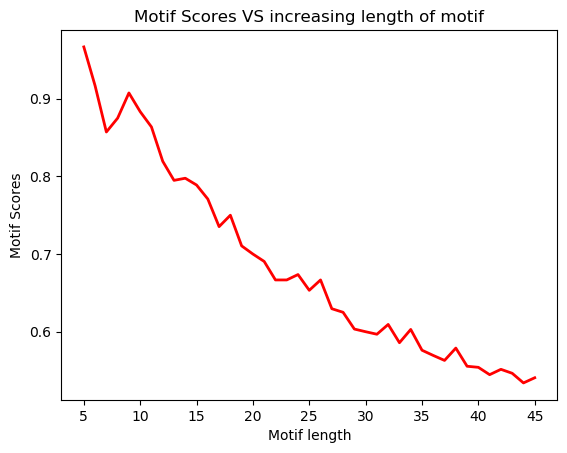

PyObject Text(0.5, 1, 'Motif Scores VS increasing length of motif')

In [15]:
plot(mo_lens, answers, color="red", linewidth=2.0, linestyle="-")
xlabel("Motif length")
ylabel("Motif Scores")
title("Motif Scores VS increasing length of motif")

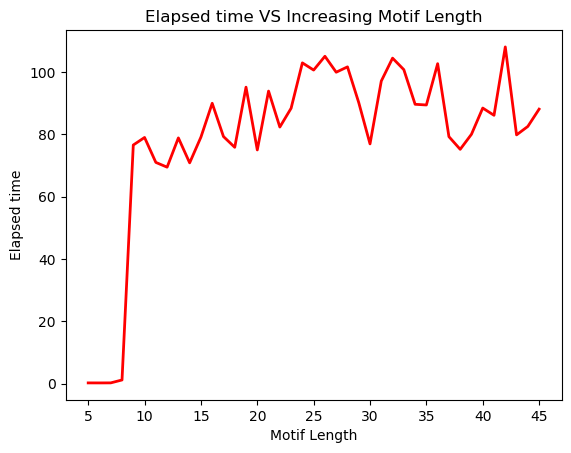

PyObject Text(0.5, 1, 'Elapsed time VS Increasing Motif Length')

In [16]:
plot(mo_lens, elapsed_times, color="red", linewidth=2.0, linestyle="-")
xlabel("Motif Length")
ylabel("Elapsed time")
title("Elapsed time VS Increasing Motif Length")